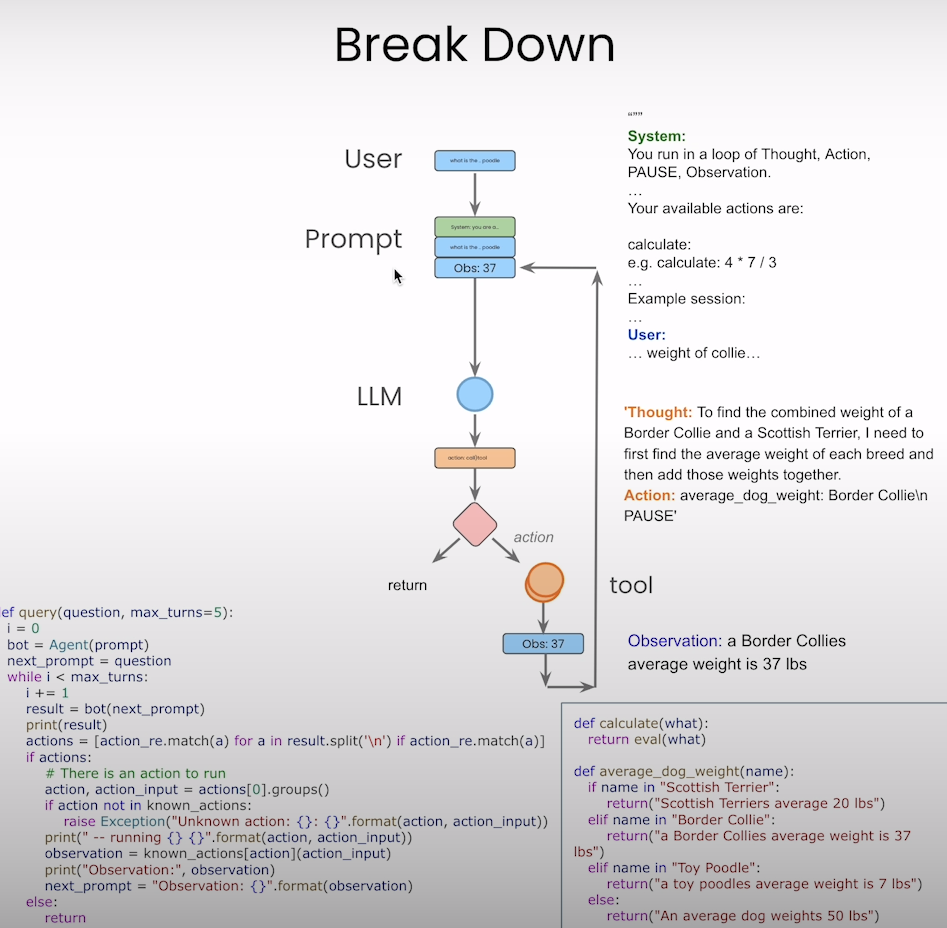

In [36]:
import google.generativeai as genai
import os, re

GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

In [20]:
class Agent:
    def __init__(self, system_instruction=""):
        self.messages = []
        self.model = genai.GenerativeModel(model_name='gemini-1.5-flash', system_instruction=system_instruction)

    def __call__(self, message):
        self.messages.append({"role": "user", "parts": [message]})
        result = self.execute()
        self.messages.append({"role": "model", "parts": [result]})
        return result

    def execute(self):
        completion = self.model.generate_content(
                        self.messages, 
                        generation_config=genai.types.GenerationConfig(
                            candidate_count=1,
                            stop_sequences=['x'],
                            max_output_tokens=1000,
                            temperature=0)
                        )
        return completion.text

In [10]:
prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

average_dog_weight:
e.g. average_dog_weight: Collie
returns average weight of a dog when given the breed

Example session:

Question: How much does a Bulldog weigh?
Thought: I should look the dogs weight using average_dog_weight
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this:

Observation: A Bulldog weights 51 lbs

You then output:

Answer: A bulldog weights 51 lbs
""".strip()

In [11]:
def calculate(what):
    return eval(what)

def average_dog_weight(name):
    if name in "Scottish Terrier": 
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        return("An average dog weights 50 lbs")

known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight
}

In [21]:
abot = Agent(prompt)

In [22]:
result = abot("How much does a toy poodle weigh?")
result

Thought: I need to find the average weight of a toy poodle. I can use the average_dog_weight action.
Action: average_dog_weight: Toy Poodle
PAUSE 



In [23]:
next_prompt = "Observation: {}".format(average_dog_weight("Toy Poodle"))

In [24]:
abot(next_prompt)

'Answer: A toy poodle weighs 6-9 lbs. \n'

In [27]:
abot.messages

[{'role': 'user', 'parts': ['How much does a toy poodle weigh?']},
 {'role': 'model',
  'parts': ['Thought: I need to find the average weight of a toy poodle. I can use the average_dog_weight action.\nAction: average_dog_weight: Toy Poodle\nPAUSE \n']},
 {'role': 'user',
  'parts': ['Observation: Thought: I need to find the average weight of a toy poodle. I can use the average_dog_weight action.\nAction: average_dog_weight: Toy Poodle\nPAUSE \n']},
 {'role': 'model', 'parts': ['Answer: A toy poodle weighs 6-9 lbs. \n']}]

In [28]:
abot = Agent(prompt)

In [29]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
abot(question)

'Thought: I need to find the average weight of each breed and then add them together.\nAction: average_dog_weight: Border Collie\nPAUSE \n'

In [30]:
next_prompt = "Observation: {}".format(average_dog_weight("Border Collie"))
print(next_prompt)

Observation: a Border Collies average weight is 37 lbs


In [31]:
abot(next_prompt)

'Thought: I now need to find the average weight of a Scottish Terrier.\nAction: average_dog_weight: Scottish Terrier\nPAUSE \n'

In [32]:
next_prompt = "Observation: {}".format(average_dog_weight("Scottish Terrier"))
print(next_prompt)

Observation: Scottish Terriers average 20 lbs


In [33]:
abot(next_prompt)

'Thought: I need to add the two weights together to get the combined weight.\nAction: calculate: 37 + 20\nPAUSE \n'

In [34]:
next_prompt = "Observation: {}".format(eval("37 + 20"))
print(next_prompt)

Observation: 57


In [35]:
abot(next_prompt)

'Answer: The combined weight of your two dogs is 57 lbs. \n'

## Add loop

In [39]:
action_re = re.compile('^Action: (\w+): (.*)$')   # python regular expression to selection action

In [40]:
def query(question, max_turns=5):
    i = 0
    bot = Agent(prompt)
    next_prompt = question
    while i < max_turns:
        i += 1
        result = bot(next_prompt)
        print(result)
        actions = [
            action_re.match(a) 
            for a in result.split('\n') 
            if action_re.match(a)
        ]
        if actions:
            # There is an action to run
            action, action_input = actions[0].groups()
            if action not in known_actions:
                raise Exception("Unknown action: {}: {}".format(action, action_input))
            print(" -- running {} {}".format(action, action_input))
            observation = known_actions[action](action_input)
            print("Observation:", observation)
            next_prompt = "Observation: {}".format(observation)
        else:
            return

In [41]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
query(question)

Thought: I need to find the average weight of each breed and then add them together.
Action: average_dog_weight: Border Collie
PAUSE 

 -- running average_dog_weight Border Collie
Observation: a Border Collies average weight is 37 lbs
Thought: I now need to find the average weight of a Scottish Terrier.
Action: average_dog_weight: Scottish Terrier
PAUSE 

 -- running average_dog_weight Scottish Terrier
Observation: Scottish Terriers average 20 lbs
Thought: I need to add the two weights together to get the combined weight.
Action: calculate: 37 + 20
PAUSE 

 -- running calculate 37 + 20
Observation: 57
Answer: The combined weight of your two dogs is 57 lbs. 

